In [1]:
import numpy as np
import pandas as pd
import random as rand_
import matplotlib.pyplot as plt

from math import pi, cos, sin, exp, floor, atan
from cmath import sqrt
from scipy.signal import StateSpace, impulse2, lsim2
from scipy.optimize import least_squares
from scipy.linalg import lstsq
from jupyterthemes import jtplot

jtplot.style()

In [2]:
class MOLIwhiteBox:
    def __init__(self, method):
        self.C = np.array([[0., 0., 0., 1.]])
        if method is None:
            method = 'trivial'
        self.filter = method
        self.structure() #defines the model structure
        self.describe() #print a model definition
        
    def structure(self):
        if self.filter == 'trivial':
            zeta = 0.
            omega = pi/12.0
            _p1 = -zeta*omega + omega*sqrt(zeta**2-1)
            _p2 = -zeta*omega - omega*sqrt(zeta**2-1)
            syscpoly = np.poly((-1.0*0.0353,_p1,_p2))
            sysc = np.concatenate((np.zeros([1]),np.flip(-syscpoly[1:])),0)
            
            A_ = np.concatenate((np.zeros([1,3]),np.identity(3)),0)
            A_ = np.concatenate((A_,sysc.reshape([4,1])),1)
            
            alphacand = np.poly(np.linalg.eig(A_)[0])
            A0 = np.concatenate((np.zeros([1,3]),np.identity(3)),0)
            A0 = np.concatenate((A0,-np.flip(alphacand[1:]).reshape([4,1])),1)
            self.A = A0
            
    def describe(self):
        print('This is a MOLI white Box alertness model')
        
    def fit(self, samples): #pipeline for simple fitting procedure  
        self.awakeRegression(samples) #determine the parameters during the day
        self.parameters(samples) #determine the bio/physical parameters
        self.sim_Back_Forward(samples) #determine the homeostatic vicinities
        self.sleepRegression() #determine the night parameters with non linear least squares
        
    def awakeRegression(self, samples): #estimate the awake white box model parameters
        size_ = len(samples['levAl'])
        #create the model structure and the filtering state-space system 
        A_, C_, I_ = np.transpose(self.A), np.transpose(self.C), np.identity(4) 
        sFilt = StateSpace(A_, C_, I_, np.zeros([4,1]))
        #create the regressor information such as the B, output and regressor
        _B, regres, _y = np.zeros([4, size_]), np.array([]), []
    
        for i in range(size_):
            #create the alerteness filtered signal and the time data
            sigAl, _time = np.asarray(samples['levAl'][i]), np.asarray(samples['time'][i])
            
            #filter the input and output signals
            time_sim = _time - _time[0] #initialize time at t[0] = 0 (hours)
            impT, impResp = impulse2(sFilt, 0, time_sim, N = 10000) #simulate B info
            outT, outResp, x2 = lsim2(sFilt, sigAl, time_sim) #simulate L info
            
            #manipulate the regressor
            comp = np.zeros([impT.size,4*size_])
            comp[:,4*i:4*(i+1)] = impResp
            aux = np.concatenate((outResp,comp),1)
            
            if i == 0: #initialize the regressor, or add info to the regressor
                regres = aux
                _y = sigAl
            else:
                regres = np.concatenate((regres, aux), 0)
                _y = np.concatenate((_y, sigAl), 0)
                
        #theta = np.linalg.lstsq(regres, _y, rcond=None)[0] #solve the regression problem
        theta = lstsq(regres, _y, overwrite_a = True, 
                      overwrite_b = True, lapack_driver = 'gelsy')[0] #'gelsy', 'gelss'
        
        #determine the parameters for each window
        for i in range(size_):
            init = 4*(i+1)
            final = 4*(i+1) + 4
            _B[:,i] = theta[init:final]
        self.L = theta[:4] #determine L 
        self.B = _B #determine several B
        
        
    def parameters(self, samples): #determine the real biologycal parameters
        Ao = self.A + np.matmul(self.L.reshape([4,1]),self.C)
        self.w = (-Ao[2,3])**0.5 #determine the frequency
        self.tau = (self.w**2)/(-Ao[1,3]) #determine the discharge component
        
        #initialize the vectors
        size_ = len(samples['levAl'])
        DC, ho = np.zeros([size_, 1]), np.zeros([size_, 1])
        cphase, M = np.zeros([size_, 1]), np.zeros([size_, 1])
        
        #create the regressor matrix to retrive the B parameters
        _X = np.array([[self.w**2, 0., 1.0/self.tau],
                       [0., 1.0/self.tau, 1.0],
                       [1.0, 1.0, 0.]])
        
        for i in range(size_):
            DC[i] = self.B[0,i]*self.tau/(self.w**2) #determine the DC level
            #remove the DC information from the data
            compensator = np.array([-DC[i]*self.w**2, -DC[i]/self.tau, -DC[i]])
            _B = self.B[1:,i].reshape(3,1) + compensator
            #solve the linear equation problem
            _Th = np.linalg.lstsq(_X, _B, rcond=None)[0]
            
            ho[i] = _Th[0]
            tan_cphase = _Th[2]/(-self.w)/_Th[1]
            
            if tan_cphase < 0: #determine the phase considering possible algebraic 
                cph = atan(tan_cphase) - pi 
            else:
                cph = atan(tan_cphase)
            cphase[i] = cph - self.w*(samples['time'][i][0] - 24*i)
            M[i] = _Th[1]/cos(cph)
            
        #estimate the parameters as the mean from each window
        self.M = np.mean(M) 
        self.DC = np.mean(DC)
        self.ho = ho
        self.cphase = np.mean(cphase)
    
    def sim_Back_Forward(self, samples):
        #initialize the output data and the real A matrix from system
        self.hNight = pd.DataFrame(columns = {'h_s','h_w','t_s','t_w'})
        Ao = self.A + np.matmul(self.L.reshape([4,1]),self.C)
        _final, size_ = 0.0, len(samples['levAl'])
        
        for i in range(size_):
            _init = 24.0*i
            dt = _init - _final
            _final = _init + samples['windDecisions'][i]
            
            if i != (size_ - 1): #if the window is the last one, don't simulate forward
                step = (_final - samples['time'][i][0]) / 100.0
                time_samp = [step*k + samples['time'][i][0] for k in range(101)]
                #simulate the model from the first sampled moment to the sleeping moment
                sysF = StateSpace(Ao, self.B[:,i].reshape([4,1]), self.C, np.zeros([1,1]))
                outT, outRes = impulse2(sysF, T = (time_samp - time_samp[0]))
                circadian = self.M*cos(self.w*time_samp[-1] + self.cphase)
                #eliminate the circadian influence from the simulated signal
                self.hNight.loc[i,'h_s'] = outRes[-1] - circadian
                self.hNight.loc[i,'t_s'] = time_samp[-1]
                
            if i != 0: #if the window is the first one, don't simulate backwards
                step_n = (samples['time'][i][0] - _init) / 100.0
                time_night = [step_n*k + _init for k in range(101)]
                #simulate the model from the first sampled moment to the awaking moment
                sysB = StateSpace(-Ao, self.B[:,i].reshape([4,1]), self.C, np.zeros([1,1]))
                #notice the negative A matrix --> backward simulation
                outT_n, outRes_n = impulse2(sysB, T = (time_night - time_night[0]))
                circadian = self.M*cos(self.w*time_night[0] + self.cphase)
                #eliminate the circadian influence from the simualted signal 
                self.hNight.loc[i-1,'h_w'] = outRes_n[-1] - circadian
                self.hNight.loc[i-1,'t_w'] = time_night[0]
                
    def cost_function(self,x,sTime,sHom,wHom): #cost function for the non linear least squares
        c = [x[0]*(1-exp(-sTime[k]/x[1])) + sHom[k]*exp(-sTime[k]/x[1]) - wHom[k] 
             for k in range(sTime.size)]
        return c
    
    def sleepRegression(self): #non linear least squares night parameters estimation
        #force the time to initialize at a zero reference
        sTime = np.asarray(self.hNight.loc[:,'t_w'].values - self.hNight.loc[:,'t_s'].values)
        #set the initial search state for the algorithm
        init__ = np.array([14.3, 2.6])
        aW, aS = self.hNight.loc[:,'h_w'].values, self.hNight.loc[:,'h_s'].values
        
        #estimate the parameters
        res_ = least_squares(self.cost_function, init__, args = (sTime, aS, aW) )
        self.sPar = res_
        self.y_ = res_.x[0]
        self.tau_e = res_.x[1]
        
    def predict(self, sTime, init_): #predict on especific moments provided a initial value
        simAl = pd.DataFrame(columns = {'dt', 'simAl', 'decision'})
        
        for i in range(sTime.shape[0]):
            alSim, timeSim = np.array([]), np.array([])
            
            # determine the day time vector -- goes from the first sample until last
            step = (sTime.loc[i,'final'] - sTime.loc[i,'init']) / 100.0
            _time_sim = np.array([sTime.loc[i,'init'] + k*step for k in range(101)])
            simAl.loc[i, 'decision'] = _time_sim[-1] 
            
            alSim = np.concatenate((alSim, self.lsim(_time_sim, init_)), 0)
            timeSim = np.concatenate((timeSim, _time_sim), 0)
            
            if i != (sTime.shape[0]-1):
                # determine the night time vector -- goes from last sample to first next day
                step = (sTime.loc[i+1,'init'] - sTime.loc[i,'final']) / 100.0
                time_night = np.array([sTime.loc[i,'final'] + k*step for k in range(101)])
                # determine the circadian during night
                circ_night = np.asarray([self.M*cos(self.w*k + self.cphase) for k in time_night])
                #eliminate the influence of the circadian process
                h_o = alSim[-1] - circ_night[0]
                nightH = [self.y_*(1-exp(-dt/self.tau_e)) + h_o*exp(-dt/self.tau_e) 
                         for dt in (time_night-time_night[0])]
                nightRes = np.asarray(nightH + circ_night)
                #reset the initial alertness level, to the last one from the night period
                init_ = nightRes[-1]
            else:
                nightRes = np.array([])
                time_night = np.array([])
            #concatenate the data for each window
            simAl.loc[i,'dt'] = np.concatenate((timeSim, time_night), 0)
            simAl.loc[i,'simAl'] = np.concatenate((alSim, nightRes), 0)
            
        return simAl
    
    def lsim(self, Ts, init_): # simulate the dinamic system during the awake period
        #determine the B matrix
        w_t = Ts[0]*self.w + self.cphase
        k_1, k_2 = self.M*cos(w_t), -self.M*sin(w_t)*self.w
        h_o = init_ - k_1 - self.DC
        Bo = [[self.DC*self.w**2/self.tau],
              [k_2/self.tau + h_o*self.w**2 + self.DC*self.w**2],
              [(k_1 + self.DC + k_2*self.tau)/self.tau],
              [h_o + k_1 + self.DC]]
        #determine the A matrix
        Ao = self.A + np.matmul(self.L.reshape([4,1]), self.C)
        #simulate the system and return the result
        sysMOLI = StateSpace(Ao, Bo, self.C, np.zeros([1,1]))
        outT, outRes = impulse2(sysMOLI, T = (Ts - Ts[0]))
        return outRes

In [3]:
class simAlert:
    def __init__(self, numDays):
        self.days = numDays
        self.time = pd.DataFrame()
        self.levAl = pd.DataFrame()
        self.levHom = pd.DataFrame()
        self.change = pd.DataFrame(columns = {'init','final'})
        self.omega = pi/12.0
        self.tau = 1/0.0353
        self.M = 2.52
        self.phi = -16.835*pi/12.0
        self.DC = 2.4
        self.y_ = 14.3
        self.tau_e = 1/0.381
        self.smpAl = pd.DataFrame(columns = {'time','levAl'} )
    
    def generate(self, windowDecision, resolution):
        initAl = 14.3
        self.resolution = resolution
        self.windows = windowDecision
        for i in range(self.days):
            unTime = [24*i + 24*j/self.resolution for j in range(resolution)]
            wTime = [j - 24*i for j in unTime if (j - 24*i) <= windowDecision[i]]
            sTime = [j - 24*i - windowDecision[i] for j in unTime 
                     if (j - 24*i) >= windowDecision[i]]
            
            circadian = [self.M*cos(self.omega*k + self.phi) for k in unTime]
            wHom = [(initAl - self.DC)*exp(-k/self.tau) + self.DC for k in wTime]
            sHom = [self.y_*(1-exp(-k/self.tau_e)) + wHom[-1]*exp(-k/self.tau_e) 
                    for k in sTime]
            Hom = np.concatenate((wHom,sHom))
            
            self.levHom.loc[:,i] = Hom[:resolution]
            self.levAl.loc[:,i] = circadian[:resolution] + Hom[:resolution]
            self.time.loc[:,i] = unTime[:resolution]
            initAl = Hom[-1]
    
    def randSample(self,ppH,seed):
        size_ = floor(max(self.windows)*ppH)
        time, levAl, day = [], [], []
        
        for i in range(self.days):
            step = floor(self.resolution/(24*ppH))
            final_ = floor(self.windows[i]*step*ppH)
            samples = range(0, final_, step)
            
            spH = floor(self.resolution/24.0)
            cruzeArr = [k - floor(spH/(2*ppH)) for k in range(0,floor(spH/ppH),1)]
            self.index = cruzeArr
            self.ind = samples
            cruzeInc = rand_.sample(cruzeArr, len(samples))
            if cruzeInc[0] < 0:
                cruzeInc[0] = 0
            if cruzeInc[-1] > 0:
                cruzeInc[-1] = 0
            samples_inc = np.asarray(cruzeInc) + samples

            time.append(list(self.time.loc[samples_inc,i].values))
            levAl.append(list(self.levAl.loc[samples_inc,i].values))
            
        self.smpAl.time = time
        self.smpAl.levAl = levAl
        samples = { 'time' : dict(self.smpAl.time),
                    'levAl' : dict(self.smpAl.levAl),
                    'windDecisions': self.windows}
        return (samples)

In [4]:
windowAwake = [16, 15.5, 16, 13]
alertData = simAlert(4) #number_days
alertData.generate(windowAwake, 100000) #window_decision, resolution
samples = alertData.randSample(2, 5) #points_per_hour (ppH), seed (random)

<IPython.core.display.Javascript object>


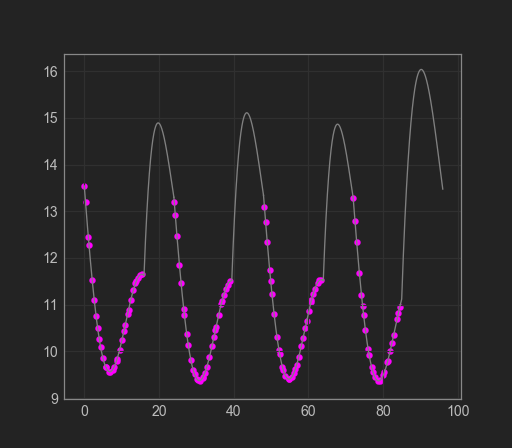

In [5]:
%matplotlib notebook
plt.plot(alertData.time, alertData.levAl, 'gray')
for i in range(alertData.smpAl.time.size):
    plt.scatter(samples['time'][i], samples['levAl'][i], c = 'fuchsia')

In [6]:
modelMOLI = MOLIwhiteBox('trivial')
modelMOLI.fit(samples)

This is a MOLI white Box alertness model


In [21]:
samples.items()

dict_items([('time', {0: [0.0, 0.33576, 1.08192, 1.27008, 2.12136, 2.67384, 3.18168, 3.56616, 4.02264, 4.368, 4.9692, 5.7252, 5.76456, 6.73008, 6.86496, 7.61064, 8.00136, 8.64456, 8.78448, 9.46392, 10.0872, 10.60008, 10.9404, 11.58384, 11.86032, 12.46056, 13.15992, 13.70328, 13.9248, 14.35392, 14.79888, 15.49752], 1: [24.09024, 24.3768, 24.82416, 25.47624, 25.9164, 26.62368, 26.82336, 27.44256, 27.858719999999998, 28.56384, 29.18208, 29.52144, 30.11376, 30.35232, 30.972, 31.67376, 31.77264, 32.30952, 32.82816, 33.53112, 34.2144, 34.732079999999996, 35.10624, 35.30928, 36.00504, 36.65832, 36.87072, 37.33536, 37.82808, 38.37336, 38.9976], 2: [48.24696, 48.5544, 49.0044, 49.654560000000004, 49.93296, 50.25528, 50.81976, 51.58896, 52.15008, 52.32072, 53.04672, 53.26152, 53.85672, 54.70824, 54.87384, 55.65144, 56.13552, 56.53032, 56.88432, 57.4236, 58.10136, 58.61376, 59.17488, 59.549279999999996, 60.11904, 60.72792, 60.849360000000004, 61.268879999999996, 61.7628, 62.47176, 62.98512, 63.49

<IPython.core.display.Javascript object>


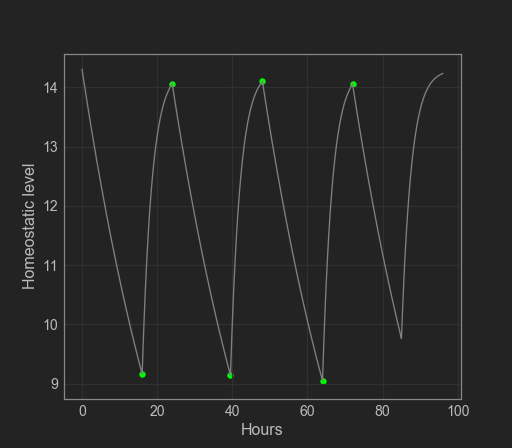

In [12]:
for i in range(alertData.time.shape[1]):
    plt.plot(alertData.time.iloc[:,i].values, alertData.levHom.iloc[:,i].values, 'grey')
    if (i != 0):
        plt.scatter(modelMOLI.hNight.loc[i-1,'t_w'], modelMOLI.hNight.loc[i-1,'h_w'], c = 'lime')
        plt.scatter(modelMOLI.hNight.loc[i-1,'t_s'], modelMOLI.hNight.loc[i-1,'h_s'], c = 'lime')
plt.xlabel('Hours')
plt.ylabel('Homeostatic level')
plt.show()

In [13]:
windowSim = [16, 15.5, 16, 13, 16.1]
alertVal = simAlert(5) #number_days
alertVal.generate(windowSim, 100000) #window_decision, resolution

#plt.plot(alertVal.time, alertVal.levAl, 'gray')
#plt.xlabel('Hours')
#plt.ylabel('Alertness level')

In [17]:
sTime = pd.DataFrame(columns = {'init','final'})
for i in range(alertVal.time.shape[1]):
    sTime.loc[i,'init'] = 24.0*i
    sTime.loc[i,'final'] = 24*i + windowSim[i]
__init = alertVal.levAl.loc[0,0]
sTime

,init,final
0,0,16
1,24,39.5
2,48,64
3,72,85
4,96,112.1


In [15]:
dtPred = modelMOLI.predict(sTime, __init)

<IPython.core.display.Javascript object>


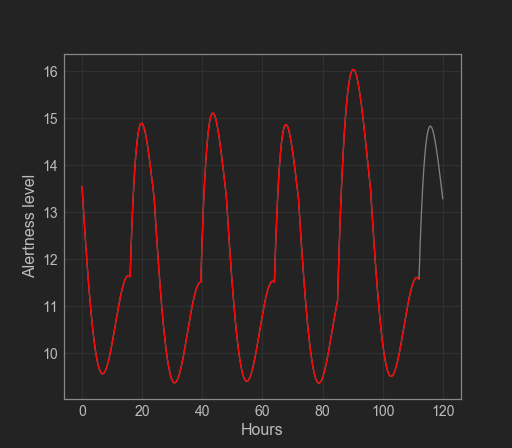

Text(0, 0.5, 'Alertness level')

In [16]:
plt.plot(alertVal.time, alertVal.levAl, 'gray')
for i in range(dtPred.dt.size):
    plt.plot(dtPred.dt.iloc[i], dtPred.simAl.iloc[i], 'red')
plt.xlabel('Hours')
plt.ylabel('Alertness level')